# Schweizer Hotels im Kantonsvergleich

### Wie sauber, freundlich und komfortabel sind Schweizer Hotels? Eine Booking.com-Bewertungs-Analyse

Für alle, die nicht in die Ferne reisen, sondern ihre diesjährigen Ferien in der Schweiz planen: Hier also noch die Schweizer Kantone im Detail mit den Codes aus dem Haupt-Notebook.

**Hinweis**: Ich habe den Code mehrmals ausgeführt, aber nicht immer dieselben Resultate erhalten. Einzelne Hotels wurden aus unerfindlichen Gründen zwei Stunden später nicht mehr angezeigt. Manchmal auch ganze Kantone. Eine Vermutung: Es zeigt bei der Abfrage via BeautifulSoup über driver.page_source der current_url nicht haargenau die gleichen Hotels an, die man via get.requests erhalten würde. 

Eine andere Vermutung ist, dass es an der Verfügbarkeit der Unterkünfte im Zeitpunkt des Scrapings liegen könnte. Manchmal setzt der Driver auf Booking.com als Datum den heutigen Tag, manchmal gar keins. Evtl. würde es helfen, ein Datum zu wählen, an dem möglichst viele Hotels offen haben. Ansonsten werden sie möglicherweise in den Suchresultaten nicht angezeigt. Die sicherste Variante ist es, den Cache zu leeren und eine Blankoabfrage (ohne Datum) zu starten.

### >>> alle nötigen Imports

In [1]:
# Für die Analyse
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np


#für Selenium
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
import time


#evtl.
import progressbar

#für Import von CVS
import csv

#evtl.
# ... s. unten with urllib.request.urlopen(hotel_link) as url:
import urllib
import urllib.request
from urllib.request import urlopen

# für Grafiken
%matplotlib inline
import geopandas as gpd
from shapely.geometry import Point, LineString, Polygon
import matplotlib.pyplot as plt
import matplotlib.pyplot as pyplot
import matplotlib as mpl





# für Regex
import re


# 1. Datenbeschaffung

### >>> Hotels und Links aller Schweizer Kantone abfragen

In [2]:
#Selenium / Webdriver öffnen (CHECK)
driver = webdriver.Chrome('/usr/local/bin/chromedriver')

#alle Unterkünfte pro Kanton abfragen

link_basis = 'https://www.booking.com/region/ch/'

# Liste aller Schweizer Kantone (so wie sie bei Booking.com abgefragt 
#werden in der Direktabfrage. Wenn ich stattdessen über das Suchfeld
#suche und z.B. Kanton Zürich, Kanton Wallis, etc. eingebe, 
# es in Kantonen, in denen der Hauptort identisch zum Kantonsamen ist,
# jeweils nach dem Hauptort. Das versuche ich hier zu umgehen)

alle_kantone_schweiz = ["zurich", 
                       "bern", 
                       "luzern", 
                       "uri", 
                       "schwyz",
                       "obwalden",
                       "nidwalden",
                       "glarus",
                       "zug", 
                       "fribourg", 
                       "solothurn",
                       "basel-stadt", 
                       "baselland", 
                       "schaffhausen",
                       "appenzell-canton", 
                       "appenzell-innerrhoden", 
                       "st-gallen-canton", 
                       "graubunden", 
                       "aargau-canton", 
                       "thurgau", 
                       "ticino", 
                       "waadt", 
                       "valais", 
                       "neuchatel", 
                       "geneve-canton", 
                       "jura"]

alle_hotels = []

#Loop über Kantone

for kanton in alle_kantone_schweiz:
    driver.get(link_basis+kanton+str('.de.html'))
    
    
    time.sleep(1)
    
    #Such-Button an klicken
    button = driver.find_element_by_class_name("sb-searchbox__button").click()
    
    #URL abspeichern
    search_page = driver.current_url
     
    time.sleep(1)
    
    driver.get(search_page)
    
    # Auswahl nur auf die Hotels 
    hotels_only = driver.find_elements_by_class_name('filter_label')

    for element in hotels_only:
        try:
            if element.text == 'Hotels':
                element.click()
        except:
            None

                  
    time.sleep(2) 

    # Quelle der Homepage herausfiltern, um sie dann gleich mit
    # BeautifulSoup zu analysieren
    hotels_homepage = driver.page_source
    soup_hotels_homepage = BeautifulSoup(hotels_homepage, 'html.parser')
   
    #Kanton 
    kantonsname = soup_hotels_homepage.find('h1').text.split(':').pop(0).replace('Kanton ','').replace('\n', '').replace(' (Kanton)','')

    # Unterkünfte-HTML-Container der ersten Seite herausfiltern für die Analyse
    accomodations = soup_hotels_homepage.find_all('div', {'data-et-view':' eWHJbWPNZWEHXT:5'})
    
    time.sleep(2)
    
    # Loop über HTML-Container
    for hotel in accomodations:
    
        #Link zur Unterkunft
        link = hotel.find('a', {'class':"hotel_name_link url"})
        link = link.get('href').replace('\n', '').split('?').pop(0).replace('/hotel', 'www.booking.com/hotel')
        
        #Name der Unterkunft
        name = hotel.find('a', {'class':"hotel_name_link"})
        name = name.text.replace('\n', '').replace('Wird in neuem Fenster geöffnet', '')
    
        #Dictionary erstellen
        dict_name_link_country = {'Name der Unterkunft': name,
                         'Link zur Unterkunft': link, 
                                 'Kanton': kantonsname}
        
        alle_hotels.append(dict_name_link_country)
           
    
    time.sleep(2)
    
    # Update: Booking baut Hürden in Form von Pop-ups ein, die ich jeweils
    #zuerst schliessen muss, bevor es weitergehen kann.
    
    try:
        popup = driver.find_element_by_class_name('sliding-panel-widget-close-button')
        popup.click()
    except:
          None
            
    # Da ich nun auch alle weitere Suchresultate sehen will, muss ich
    # jeweils auf den Pfeil klicken, um zur nächsten Übersichtsseite
    # zu gelangen. Um zu wissen, wie oft das Programm klicken soll, 
    # muss ich wissen, wie viele Suchresultateseiten es gibt. 
    # Dafür wähle ich das letzte Element in der Liste und lasse 
    # die Zahl ausgeben
    
    try:
        #Liste Paginierung herausfiltern
        pages = soup_hotels_homepage.find_all('li', {'class':"sr_pagination_item"})
    
        #letztes Element in Liste, bzw. letzte Suchseite anwählen 
        # und Zahl ausgeben
        anzahl_suchseiten = pages.pop().text
    except:
        None
    
    
    #nun eine Funktion einbauen, die ich in der Anzahl der soeben 
    #bestimmten Suchseiten durchlaufen lasse
    
    
    
    # Update: Booking baut Hürden in Form von Pop-ups ein, die ich jeweils
    #zuerst schliessen muss, bevor es weitergehen kann. 
    
    try:
        popup = driver.find_element_by_class_name('sliding-panel-widget-close-button')
        popup.click()
    except:
          None
    
    
    time.sleep(1)

  # Schlaufe Funktion Seitenabfrage einfügen
    
    try:
        x = 1
        while x < int(anzahl_suchseiten):
            
            x = x + 1
        
            #klick auf den Pfeil, denn dann hat es noch mehr Suchresultate
            hotels_next_page = driver.find_element_by_class_name("bui-pagination__next-arrow")
            hotels_next_page.click()
            
            time.sleep(2)
    
            #Information der Seite abfragen
            hotels_next_page = driver.page_source
            
            time.sleep(1)
    
            #neuer Loop 2. Suchresultateseite
            soup_hotels_next_page = BeautifulSoup(hotels_next_page, 'html.parser')
            accomodations = soup_hotels_next_page.find_all('div', {'data-et-view':' eWHJbWPNZWEHXT:5'})

            time.sleep(2)
        
            for hotel in accomodations:
            
                #Link zur Unterkunft
                link = hotel.find('a', {'class':"hotel_name_link url"})
                link = link.get('href').replace('\n', '').split('?').pop(0).replace('/hotel', 'www.booking.com/hotel')
            
                #Name der Unterkunft
                name = hotel.find('a', {'class':"hotel_name_link"})
                name = name.text.replace('\n', '').replace('Wird in neuem Fenster geöffnet', '')
    
                #Dictionary erstellen
                dict_name_link_country = {'Name der Unterkunft': name,
                         'Link zur Unterkunft': link,
                                         'Kanton': kantonsname}
        
                alle_hotels.append(dict_name_link_country)
        
            time.sleep(1)
    except:
        None
        
    
driver.close

#Dataframe erstellen
    
df_alle_hotels = pd.DataFrame(alle_hotels)
df_alle_hotels
    
    
#In CSV abspeichern

df_alle_hotels.to_csv('Alle_Hotels_Schweiz.csv')    
    
    
    

    
    



In [3]:
len(alle_hotels)

3092

In [4]:
df_alle_hotels['Kanton'].value_counts()

Graubünden                517
Wallis                    501
Bern                      461
Tessin                    267
Zürich                    244
Luzern                    156
St. Gallen                139
Genf                      110
Aargau                     93
Freiburg                   71
Thurgau                    69
Basel-Stadt                68
Schwyz                     48
Obwalden                   47
Solothurn                  46
Neuenburg                  41
Uri                        34
Jura                       31
Basel-Landschaft           26
Appenzell Ausserrhoden     22
Nidwalden                  22
Appenzell Innerrhoden      21
Zug                        20
Schaffhausen               19
Glarus                     19
Name: Kanton, dtype: int64

In [5]:
# Hoppla, der Kanton Waadt fehlt.
# Also noch eine separate Abfrage von Hand (bwz. mit Direktlink).

#Selenium / Webdriver öffnen (CHECK)
driver = webdriver.Chrome('/usr/local/bin/chromedriver')

#url des Booking ansteuern
url = 'https://www.booking.com/index.de.html?label=gen173nr-1DCAEoggI46AdIM1gEaCyIAQGYAQe4AQfIAQzYAQPoAQGIAgGoAgM;sid=bac122b1b039d543c04b493f5e62a162;keep_landing=1&sb_price_type=total&'
driver.get(url)
    
time.sleep(1)
    
#Suchfeld anwählen
suchfeld = driver.find_element_by_name("ss")
suchfeld.send_keys("Kanton Waadt")

time.sleep(2)

#«Suche»-Button ansteuern, um zur Übersicht aller Unterkünfte zu gelangen
button = driver.find_element_by_class_name("sb-searchbox__button").click()
        
# Auswahl nur auf die Hotels
hotels_only = driver.find_elements_by_class_name('filter_label')

for element in hotels_only:
    try:
        if element.text == 'Hotels':
            element.click()
    except:
        None

                  
time.sleep(2) 

# Quelle der Homepage herausfiltern, um sie dann gleich mit
# BeautifulSoup zu analysieren
hotels_homepage = driver.page_source
soup_hotels_homepage = BeautifulSoup(hotels_homepage, 'html.parser')
   
#Kanton 
kantonsname = soup_hotels_homepage.find('h1').text.split(':').pop(0).replace('\n', '').replace('Kanton ', '').replace('"', '').replace(', Switzerland','')
    
# Übersicht Unterkünfte einer Seite
accomodations = soup_hotels_homepage.find_all('div', {'data-et-view':' eWHJbWPNZWEHXT:5'})
 
alle_hotels_vd = []

# Loop
for hotel in accomodations:
    #Link zur Unterkunft
    link = hotel.find('a', {'class':"hotel_name_link url"})
    link = link.get('href').replace('\n', '').split('?').pop(0).replace('/hotel', 'www.booking.com/hotel')
        
    #Name der Unterkunft
    name = hotel.find('a', {'class':"hotel_name_link"})
    name = name.text.replace('\n', '').replace('Wird in neuem Fenster geöffnet', '')
    
    #Dictionary erstellen
    dict_name_link_country = {'Name der Unterkunft': name,
                         'Link zur Unterkunft': link, 
                                 'Kanton': kantonsname}
        
    alle_hotels_vd.append(dict_name_link_country)
           
    
time.sleep(2)
    
    # Update: Booking baut Hürden in Form von Pop-ups ein, die ich jeweils
    #zuerst schliessen muss, bevor es weitergehen kann.
    
try:
    popup = driver.find_element_by_class_name('sliding-panel-widget-close-button')
    popup.click()
except:
    None
            
    # Da ich nun auch alle weitere Suchresultate sehen will, muss ich
    # jeweils auf den Pfeil klicken, um zur nächsten Übersichtsseite
    # zu gelangen. Um zu wissen, wie oft das Programm klicken soll, 
    # muss ich wissen, wie viele Suchresultateseiten es gibt. 
    # Dafür wähle ich das letzte Element in der Liste und lasse 
    # die Zahl ausgeben
    
try:
        #Liste Paginierung herausfiltern
    pages = soup_hotels_homepage.find_all('li', {'class':"sr_pagination_item"})
    
        #letztes Element in Liste, bzw. letzte Suchseite anwählen 
        # und Zahl ausgeben
    anzahl_suchseiten = pages.pop().text
except:
    None
    
    
    # Update: Booking baut Hürden in Form von Pop-ups ein, die ich jeweils
    #zuerst schliessen muss, bevor es weitergehen kann. 
    
try:
    popup = driver.find_element_by_class_name('sliding-panel-widget-close-button')
    popup.click()
except:
    None
    
    
time.sleep(1)

  # Schlaufe Funktion Seitenabfrage einfügen
    
try:
    x = 1
    while x < int(anzahl_suchseiten):
                
        x = x + 1
        
        #klick auf den Pfeil, denn dann hat es noch mehr Suchresultate
        hotels_next_page = driver.find_element_by_class_name("bui-pagination__next-arrow")
        hotels_next_page.click()
    
    
        #Information der Seite abfragen
        hotels_next_page = driver.page_source
    
        #neuer Loop 2. Suchresultateseite
        soup_hotels_next_page = BeautifulSoup(hotels_next_page, 'html.parser')
        accomodations = soup_hotels_next_page.find_all('div', {'data-et-view':' eWHJbWPNZWEHXT:5'})

        time.sleep(1)
        
        for hotel in accomodations:
            
            #Link zur Unterkunft
            link = hotel.find('a', {'class':"hotel_name_link url"})
            link = link.get('href').replace('\n', '').split('?').pop(0).replace('/hotel', 'www.booking.com/hotel')
            
            #Name der Unterkunft
            name = hotel.find('a', {'class':"hotel_name_link"})
            name = name.text.replace('\n', '').replace('Wird in neuem Fenster geöffnet', '')
    
            #Dictionary erstellen
            dict_name_link_country = {'Name der Unterkunft': name,
                         'Link zur Unterkunft': link,
                                         'Kanton': kantonsname}
        
            alle_hotels_vd.append(dict_name_link_country)
        
        time.sleep(1)
except:
    None
        
    
driver.close

#Dataframe erstellen
    
df_alle_hotels_vd = pd.DataFrame(alle_hotels_vd)
df_alle_hotels_vd
    
    
#In CSV abspeichern

df_alle_hotels_vd.to_csv('Alle_Hotels_Waadt.csv')    
    
    
    



In [6]:
print(kantonsname)

Waadt


In [7]:
len(df_alle_hotels_vd)

247

In [8]:
# beide CSV zusammenfügen (CH und Waadt)
df1 = pd.read_csv('Alle_Hotels_Schweiz.csv')

df2 = pd.read_csv('Alle_Hotels_Waadt.csv')

df_all_hotels_ch_total = pd.concat([df1, df2], ignore_index=True)

#CSV des kompletten DataFrames erstellen
df_all_hotels_ch_total.to_csv('Alle_Hotels_Schweiz_neu.csv')


In [9]:
len(df_all_hotels_ch_total)

3339

In [10]:
# Es hat ein paar Fehler beim Scrapen der Mail-Adressen gegeben. 
# Die versuche ich hier nun auszumerzen, damit sie abrufbar sind. 

path_ch = 'Alle_Hotels_Schweiz_neu.csv'
df_ch = pd.read_csv(path_ch)


links_hotels_ch = []

for link in df_ch['Link zur Unterkunft']:
    try:
        link = link.replace('chwww.booking.com', 'ch')
    except:
        None
    
    links_hotels_ch.append(link)
    
df_ch['Link zur Unterkunft'] = links_hotels_ch

df_ch.to_csv('Alle_Hotels_Schweiz_www.csv')

### >>> Detailabfrage der Bewertungen aller Hotels in der Schweiz

In [12]:
#Ich kopiere den Link aus der weltweiten Booking-Abfrage (erstes Notebook) und lasse den Code
# über alle Hotellinks der Schweiz loopen


#Pfad mit korrigierten Links einlesen
path_ch = 'Alle_Hotels_Schweiz_www.csv'
df_ch = pd.read_csv(path_ch)

hoteldetails = []

for directlink_hotel in df_ch['Link zur Unterkunft']:

    directlink_hotel = str('https://')+directlink_hotel

    hotel_page = requests.get(directlink_hotel).text
    soup_hotel_page = BeautifulSoup(hotel_page, 'html.parser')
    
    #Art der Unterkunft
    try:
        type_accomodation = soup_hotel_page.find('span', {'class':"hp__hotel-type-badge"}).text
    except:
        type_accomodation = 'NaN'

    #Name des Hotels
    try:
        name = soup_hotel_page.find('a', {'id':"hp_hotel_name_reviews"}).text.replace('\n', '')
    except:
        name = 'NaN'

    #Anzahl Sterne
    try:
        stars = soup_hotel_page.find('span', {'class':"hp__hotel_ratings__stars nowrap"}).text.replace('\n', '').replace('-Sterne-Hotel','')
    except:
        stars = 'NaN'

    #Gesamtnote
    try:
        score = soup_hotel_page.find('div', {'class':"bui-review-score__badge"}).text.replace('Wird in neuem Fenster geöffnet', '').replace('    Sehr gut   ', ';').split(';').pop(0)
    except:
        score = 'NaN'

    #Anzahl Bewertungen
    try:
        reviews = soup_hotel_page.find('div', {'class':"bui-review-score__text"}).text.replace(' Bewertungen','')
    except:
        reviews = 'NaN'

    #Adresse
    try:
        address = soup_hotel_page.find('span', {'class':"hp_address_subtitle"}).text.replace('\n', '')
    except:
        address = 'NaN'

    #Ort
    try:
        ort = soup_hotel_page.find('a', {'href':"#map_opened-hotel_header"}).get('data-atlas-latlng')
    except:
        ort = 'NaN'

    #Land
    try:
        land = soup_hotel_page.find('span', {'class':"hp_address_subtitle"}).text.replace('\n', '').split(',').pop()
    except:
        land = 'NaN'

    #Ausstattung
    try:
        equipment = soup_hotel_page.find('li', {'data-question':"hotel_services"}).text.replace('\n', '').replace('Ausstattung', '')
    except:
        equipment = 'NaN'

    #Sauberkeit
    try:
        sauberkeit = soup_hotel_page.find('li', {'data-question':"hotel_clean"}).text.replace('\n', '').replace('Sauberkeit', '')
    except:
        sauberkeit = 'NaN'

    #Komfort
    try:
        comfort = soup_hotel_page.find('li', {'data-question':"hotel_comfort"}).text.replace('\n', '').replace('Komfort', '')
    except:
        comfort = 'NaN'

    #Preis/Leistung
    try:
        value = soup_hotel_page.find('li', {'data-question':"hotel_value"}).text.replace('\n', '').replace('Preis-Leistungs-Verhältnis', '')
    except:
        value = 'NaN'

    #Lage
    try:
        location = soup_hotel_page.find('li', {'data-question':"hotel_location"}).text.replace('\n', '').replace('Lage', '')
    except:
        location = 'NaN'

    #Personal
    try:
        staff = soup_hotel_page.find('span', {"c-score-bar__score"}).text
    except:
        staff = 'NaN'

    #Dictionary erstellen
    dict_hoteldetails = {'Art der Unterkunft': type_accomodation, 
                               'Name des Hotels': name,
                                'Anzahl Sterne': stars, 
                                'Gesamtnote': score,
                                'Anzahl Bewertungen': reviews,
                                'Ort': ort, 
                                'Adresse': address, 
                                'Ausstattung': equipment, 
                                'Sauberkeit': sauberkeit, 
                                'Komfort': comfort,
                                'Preis/Leistung': value,
                                'Lage': location, 
                                'Hotelpersonal': staff, 
                                'Link zu Unterkunft': directlink_hotel, 
                                'Land': land}

    hoteldetails.append(dict_hoteldetails)

#DataFrame erstellen
df_hoteldetails = pd.DataFrame(hoteldetails)

    
#In CSV abspeichern

df_hoteldetails.to_csv('Details_alle_Hotels_Schweiz.csv')
                                 

In [13]:
# Ich füge noch eine Kantonsspalte ein
# mit dem Inhalt der Kantonsspalte aus dem ersten CSV
df_hoteldetails['Kanton'] = df_alle_hotels['Kanton']
df_hoteldetails

,Adresse,Anzahl Bewertungen,Anzahl Sterne,Art der Unterkunft,Ausstattung,Gesamtnote,Hotelpersonal,Komfort,Lage,Land,Link zu Unterkunft,Name des Hotels,Ort,Preis/Leistung,Sauberkeit,Kanton
0,"Ohringerstrasse 2, 8472 Seuzach, Schweiz",63,,Hotel,"9,2","9,1","9,2","9,4","8,5",Schweiz,https://www.booking.com/hotel/ch/sonne-seuzach...,Hotel Sonne Seuzach,"47.53626200,8.72925700","8,7","9,5",Zürich
1,"6 Richtistrasse, 8304 Wallisellen, Schweiz",52,3,Hotel,"7,8","8,1","8,4","8,0","7,0",Schweiz,https://www.booking.com/hotel/ch/b-amp-b-zuric...,B&B Hotel Zürich Wallisellen,"47.41197700,8.59312900","8,1","9,2",Zürich
2,"Im Zentrum 2, 8105 Regensdorf, Schweiz",979,4,Hotel,"8,1","8,1","8,3","8,4","7,5",Schweiz,https://www.booking.com/hotel/ch/moevenpickhot...,Mövenpick Hotel Zürich-Regensdorf,"47.43107031,8.46756220","7,6","8,7",Zürich
3,"Konradstrasse 39, Gewerbeschule, 8005 Zürich, ...",3.756,3,Hotel,"7,9","8,3","8,7","8,0","9,0",Schweiz,https://www.booking.com/hotel/ch/bookingsbestw...,Hotel Montana Zürich,"47.38082231,8.53534698","7,9","8,6",Zürich
4,"Holbergstrasse 1, 8302 Kloten, Schweiz",3.210,3,Hotel,"8,4","8,8","8,9","8,6","8,9",Schweiz,https://www.booking.com/hotel/ch/welcome-inn.d...,Hotel Welcome Inn,"47.44919265,8.58158089","8,4","9,2",Zürich
5,"Bahnhofstrasse 87, Stadtzentrum, 8021 Zürich, ...",2.220,4,Hotel,"8,0","8,4","8,6","8,2","9,5",Schweiz,https://www.booking.com/hotel/ch/gotthard.de.html,Hotel St.Gotthard,"47.37645421,8.53927910","7,4","8,7",Zürich
6,"Hohlstrasse 18, Aussersihl, 8004 Zürich, Schweiz",808,3,Hotel,"7,6","7,7","7,9","7,7","7,1",Schweiz,https://www.booking.com/hotel/ch/trip-inn-zuri...,Trip Inn Zurich Hotel,"47.37710100,8.52754600","7,4","8,6",Zürich
7,"Hofstrasse 21, 8181 Höri, Schweiz",344,3,Hotel,"7,7","7,5","6,7","7,9","6,7",Schweiz,https://www.booking.com/hotel/ch/hotelhoerinn-...,Hotel Höri Inn,"47.51231400,8.51930603","7,4","8,4",Zürich
8,"Walter-Mittelholzer-Strasse 8, 8152 Glattbrugg...",1.756,4,Hotel,"7,9","8,2","8,1","8,2","8,5",Schweiz,https://www.booking.com/hotel/ch/movenpickzuri...,Mövenpick Hotel Zürich-Airport,"47.43963382,8.56856883","7,5","8,6",Zürich
9,"Boldernstrasse 83, 8708 Männedorf, Schweiz",490,3,Hotel,"7,7","8,3","8,7","7,6","9,0",Schweiz,https://www.booking.com/hotel/ch/boldern-evang...,Hotel Boldern,"47.26219769,8.70198190","7,6","8,8",Zürich


### >>> Allfällige Link-Doubletten herausfiltern
Bei manchen Kantonen werden in manchen Durchläufen die ersten 15 Hotels doppelt eingelesen. Die  allfälligen Doubletten merze ich hier nun aus. 

In [16]:
df_hoteldetails.drop_duplicates(subset='Link zu Unterkunft', keep='first', inplace=False)

,Adresse,Anzahl Bewertungen,Anzahl Sterne,Art der Unterkunft,Ausstattung,Gesamtnote,Hotelpersonal,Komfort,Lage,Land,Link zu Unterkunft,Name des Hotels,Ort,Preis/Leistung,Sauberkeit,Kanton
0,"Ohringerstrasse 2, 8472 Seuzach, Schweiz",63,,Hotel,"9,2","9,1","9,2","9,4","8,5",Schweiz,https://www.booking.com/hotel/ch/sonne-seuzach...,Hotel Sonne Seuzach,"47.53626200,8.72925700","8,7","9,5",Zürich
1,"6 Richtistrasse, 8304 Wallisellen, Schweiz",52,3,Hotel,"7,8","8,1","8,4","8,0","7,0",Schweiz,https://www.booking.com/hotel/ch/b-amp-b-zuric...,B&B Hotel Zürich Wallisellen,"47.41197700,8.59312900","8,1","9,2",Zürich
2,"Im Zentrum 2, 8105 Regensdorf, Schweiz",979,4,Hotel,"8,1","8,1","8,3","8,4","7,5",Schweiz,https://www.booking.com/hotel/ch/moevenpickhot...,Mövenpick Hotel Zürich-Regensdorf,"47.43107031,8.46756220","7,6","8,7",Zürich
3,"Konradstrasse 39, Gewerbeschule, 8005 Zürich, ...",3.756,3,Hotel,"7,9","8,3","8,7","8,0","9,0",Schweiz,https://www.booking.com/hotel/ch/bookingsbestw...,Hotel Montana Zürich,"47.38082231,8.53534698","7,9","8,6",Zürich
4,"Holbergstrasse 1, 8302 Kloten, Schweiz",3.210,3,Hotel,"8,4","8,8","8,9","8,6","8,9",Schweiz,https://www.booking.com/hotel/ch/welcome-inn.d...,Hotel Welcome Inn,"47.44919265,8.58158089","8,4","9,2",Zürich
5,"Bahnhofstrasse 87, Stadtzentrum, 8021 Zürich, ...",2.220,4,Hotel,"8,0","8,4","8,6","8,2","9,5",Schweiz,https://www.booking.com/hotel/ch/gotthard.de.html,Hotel St.Gotthard,"47.37645421,8.53927910","7,4","8,7",Zürich
6,"Hohlstrasse 18, Aussersihl, 8004 Zürich, Schweiz",808,3,Hotel,"7,6","7,7","7,9","7,7","7,1",Schweiz,https://www.booking.com/hotel/ch/trip-inn-zuri...,Trip Inn Zurich Hotel,"47.37710100,8.52754600","7,4","8,6",Zürich
7,"Hofstrasse 21, 8181 Höri, Schweiz",344,3,Hotel,"7,7","7,5","6,7","7,9","6,7",Schweiz,https://www.booking.com/hotel/ch/hotelhoerinn-...,Hotel Höri Inn,"47.51231400,8.51930603","7,4","8,4",Zürich
8,"Walter-Mittelholzer-Strasse 8, 8152 Glattbrugg...",1.756,4,Hotel,"7,9","8,2","8,1","8,2","8,5",Schweiz,https://www.booking.com/hotel/ch/movenpickzuri...,Mövenpick Hotel Zürich-Airport,"47.43963382,8.56856883","7,5","8,6",Zürich
9,"Boldernstrasse 83, 8708 Männedorf, Schweiz",490,3,Hotel,"7,7","8,3","8,7","7,6","9,0",Schweiz,https://www.booking.com/hotel/ch/boldern-evang...,Hotel Boldern,"47.26219769,8.70198190","7,6","8,8",Zürich


In [17]:
#neues CSV erstellen mit dem bereinigten DataFrame
df_hoteldetails.to_csv('Details_alle_Hotels_Schweiz_bereinigt.csv')

# 2. Analyse der Daten

In [18]:
# Übersicht Details Hotels einlesen
path_ch = 'Details_alle_Hotels_Schweiz_bereinigt.csv'
df_ch = pd.read_csv(path_ch)

In [19]:
df_ch.head(3)

,Unnamed: 0,Adresse,Anzahl Bewertungen,Anzahl Sterne,Art der Unterkunft,Ausstattung,Gesamtnote,Hotelpersonal,Komfort,Lage,Land,Link zu Unterkunft,Name des Hotels,Ort,Preis/Leistung,Sauberkeit,Kanton
0,0,"Ohringerstrasse 2, 8472 Seuzach, Schweiz",63.0,NaN,Hotel,"9,2","9,1","9,2","9,4","8,5",Schweiz,https://www.booking.com/hotel/ch/sonne-seuzach...,Hotel Sonne Seuzach,"47.53626200,8.72925700","8,7","9,5",Zürich
1,1,"6 Richtistrasse, 8304 Wallisellen, Schweiz",52.0,3,Hotel,"7,8","8,1","8,4","8,0","7,0",Schweiz,https://www.booking.com/hotel/ch/b-amp-b-zuric...,B&B Hotel Zürich Wallisellen,"47.41197700,8.59312900","8,1","9,2",Zürich
2,2,"Im Zentrum 2, 8105 Regensdorf, Schweiz",979.0,4,Hotel,"8,1","8,1","8,3","8,4","7,5",Schweiz,https://www.booking.com/hotel/ch/moevenpickhot...,Mövenpick Hotel Zürich-Regensdorf,"47.43107031,8.46756220","7,6","8,7",Zürich


In [20]:
# Es haben sich ein paar französische Hotels aus der Genferseeregion 
# eingeschlichen, auf die ich aber hier verzichte
df_ch_only = df_ch[df_ch['Land'] == ' Schweiz']


In [21]:
# Wegen allfälligen Fehlermeldungen speichere ich das neue DataFrame
# als CSV ab und lese es nochmals ein. 

df_ch_only.to_csv('Neu_Details_alle_Hotels_CH')



In [22]:
path_ch_neu = 'Neu_Details_alle_Hotels_CH'
df_ch = pd.read_csv(path_ch_neu)
df_ch.head()

,Unnamed: 0,Unnamed: 0.1,Adresse,Anzahl Bewertungen,Anzahl Sterne,Art der Unterkunft,Ausstattung,Gesamtnote,Hotelpersonal,Komfort,Lage,Land,Link zu Unterkunft,Name des Hotels,Ort,Preis/Leistung,Sauberkeit,Kanton
0,0,0,"Ohringerstrasse 2, 8472 Seuzach, Schweiz",63.000,NaN,Hotel,"9,2","9,1","9,2","9,4","8,5",Schweiz,https://www.booking.com/hotel/ch/sonne-seuzach...,Hotel Sonne Seuzach,"47.53626200,8.72925700","8,7","9,5",Zürich
1,1,1,"6 Richtistrasse, 8304 Wallisellen, Schweiz",52.000,3,Hotel,"7,8","8,1","8,4","8,0","7,0",Schweiz,https://www.booking.com/hotel/ch/b-amp-b-zuric...,B&B Hotel Zürich Wallisellen,"47.41197700,8.59312900","8,1","9,2",Zürich
2,2,2,"Im Zentrum 2, 8105 Regensdorf, Schweiz",979.000,4,Hotel,"8,1","8,1","8,3","8,4","7,5",Schweiz,https://www.booking.com/hotel/ch/moevenpickhot...,Mövenpick Hotel Zürich-Regensdorf,"47.43107031,8.46756220","7,6","8,7",Zürich
3,3,3,"Konradstrasse 39, Gewerbeschule, 8005 Zürich, ...",3.756,3,Hotel,"7,9","8,3","8,7","8,0","9,0",Schweiz,https://www.booking.com/hotel/ch/bookingsbestw...,Hotel Montana Zürich,"47.38082231,8.53534698","7,9","8,6",Zürich
4,4,4,"Holbergstrasse 1, 8302 Kloten, Schweiz",3.210,3,Hotel,"8,4","8,8","8,9","8,6","8,9",Schweiz,https://www.booking.com/hotel/ch/welcome-inn.d...,Hotel Welcome Inn,"47.44919265,8.58158089","8,4","9,2",Zürich


In [105]:
# Den Kantonsnamen von Waadt hat es nicht übernommen. Ich ersetze also die
# NaN durch Waadt

# Den Kantonsnamen von Waadt hat es nicht übernommen. Ich ersetze also die
# NaN durch Waadt

df_ch['Kanton'].fillna('Waadt', inplace=True)


### >>> Bewertungsspalten von Strings in Floats umwandeln

In [24]:
df_ch['Gesamtnote'] = df_ch['Gesamtnote'].replace(",",".", regex=True).replace("Gesamtnote", "NaN").astype(float)
# Median Gesamtnote
df_ch['Gesamtnote'].median().round(1)

8.6

In [25]:
df_ch['Sauberkeit'] = df_ch['Sauberkeit'].replace(",",".", regex=True).replace("Sauberkeit", "NaN").astype(float)
# Median Sauberkeit
df_ch['Sauberkeit'].median().round(1)

9.1

In [26]:
df_ch['Hotelpersonal'] = df_ch['Hotelpersonal'].replace(",",".", regex=True).replace('Hotelpersonal','NaN', regex=True).astype(float)
# Median Hotelpersonal
df_ch['Hotelpersonal'].median().round(1)

9.0

In [27]:
df_ch['Lage'] = df_ch['Lage'].replace(",",".", regex=True).replace('Lage','NaN', regex=True).astype(float)
# Median Lage
df_ch['Lage'].median().round(1)

8.9

In [28]:
df_ch['Preis/Leistung'] = df_ch['Preis/Leistung'].replace(",",".", regex=True).replace('Preis/Leistung','NaN', regex=True).astype(float)
# Median Lage
df_ch['Preis/Leistung'].median().round(1)

8.0

In [29]:
df_ch['Komfort'] = df_ch_only['Komfort'].replace(",",".", regex=True).replace('Komfort','NaN', regex=True).astype(float)
# Median Komfort
df_ch['Komfort'].median().round(1)

8.3

In [30]:
df_ch['Ausstattung'] = df_ch['Ausstattung'].replace(",",".", regex=True).replace('Ausstattug','NaN', regex=True).astype(float)
# Median Ausstattung
df_ch['Ausstattung'].median().round(1)

8.2

> Erkenntnis: Bei der Sauberkeit und Freundlichkeit sind wir top mit Noten um 9 herum. Aber die Preis/Leistung lässt mit Note 8 zu wünschen übrig. Nachholbedarf bei Komfort und Ausstattung. 

In [31]:
#Bewertungen gruppieren
bewertungen_only = df_ch[['Kanton', 'Gesamtnote', 'Sauberkeit', 'Hotelpersonal', 'Komfort', 'Lage', 'Ausstattung', 'Preis/Leistung']]
bewertungen_only.head(5)

,Kanton,Gesamtnote,Sauberkeit,Hotelpersonal,Komfort,Lage,Ausstattung,Preis/Leistung
0,Zürich,9.1,9.5,9.2,9.4,8.5,9.2,8.7
1,Zürich,8.1,9.2,8.4,8.0,7.0,7.8,8.1
2,Zürich,8.1,8.7,8.3,8.4,7.5,8.1,7.6
3,Zürich,8.3,8.6,8.7,8.0,9.0,7.9,7.9
4,Zürich,8.8,9.2,8.9,8.6,8.9,8.4,8.4


In [32]:
# Liste Kantone für spätere Abfrage
liste_kantone = ['Zürich',
                'Bern',
                'Luzern',
                'Uri',
                'Schwyz',
                'Obwalden',
                'Nidwalden',
                'Glarus',
                'Zug',
                'Freiburg',
                'Solothurn',
                'Basel-Stadt',
                'Basel-Landschaft',
                'Schaffhausen',
                'Appenzell Ausserrhoden',
                'Appenzell Innerrhoden',
                 'St. Gallen',
                 'Graubünden',
                 'Aargau',
                 'Thurgau',
                 'Tessin',
                 'Wallis',
                 'Neuenburg',
                 'Genf',
                 'Jura',
                 'Waadt']


### >>> Funktionen schreiben für spätere Abfragen

In [34]:
# Median jeder Bewertungsspalte pro Kanton

median = []

def abfrage_median (kanton):
    one_kanton = df_ch['Kanton'] == str(kanton)
    gesamtnote = df_ch[one_kanton]['Gesamtnote'].median()
    sauberkeit = df_ch[one_kanton]['Sauberkeit'].median()
    hotelpersonal = df_ch[one_kanton]['Hotelpersonal'].median()
    komfort = df_ch[one_kanton]['Komfort'].median()
    ausstattung = df_ch[one_kanton]['Ausstattung'].median()
    lage = df_ch[one_kanton]['Lage'].median()
    preis_leistung = df_ch[one_kanton]['Preis/Leistung'].median()
    
    
    dict_median = {'Kanton': kanton, 
                  'Gesamtnote Median': gesamtnote, 
                  'Sauberkeit Median': sauberkeit,
                  'Hotelpersonal Median': hotelpersonal,
                  'Komfort Median': komfort,
                  'Ausstattung Median': ausstattung, 
                  'Lage Median': lage, 
                  'Preis/Leistung Median': preis_leistung}
    
    median.append(dict_median)
    

In [35]:
# Übersichtstabelle aller Kantone mit allen Median-Werten
median = []

for kanton in liste_kantone:
    abfrage_median(kanton)
    
df_median = pd.DataFrame(median)
df_median


,Ausstattung Median,Gesamtnote Median,Hotelpersonal Median,Kanton,Komfort Median,Lage Median,Preis/Leistung Median,Sauberkeit Median
0,8.20,8.4,8.70,Zürich,8.20,8.50,7.70,8.90
1,8.10,8.5,9.00,Bern,8.20,8.90,7.90,9.00
2,8.00,8.4,8.80,Luzern,8.10,8.90,7.70,8.90
3,7.70,8.4,9.00,Uri,7.95,8.65,7.50,8.90
4,8.10,8.5,9.00,Schwyz,8.20,8.90,7.90,9.00
5,8.40,8.7,9.10,Obwalden,8.40,9.00,8.00,9.20
6,8.30,8.6,8.95,Nidwalden,8.10,9.05,7.80,9.05
7,7.25,8.1,8.95,Glarus,7.30,8.60,7.45,8.75
8,8.15,8.4,8.70,Zug,8.25,8.50,7.45,9.00
9,7.90,8.4,8.70,Freiburg,8.00,8.60,7.90,8.80


In [106]:
#DataFrame erstellen
df_median.to_csv('Tabelle Medianwerte Benotungen.csv')

### >>> Gesamtnote

In [36]:
# Welcher Kanton hat den höchsten/niedrigsten Gesamtnotendurchschnitt?
df_median.groupby('Kanton')['Gesamtnote Median'].max().round(1).sort_values(ascending=False)

Kanton
Appenzell Innerrhoden     9.0
Graubünden                8.8
Wallis                    8.8
Appenzell Ausserrhoden    8.7
Obwalden                  8.7
Basel-Stadt               8.6
Nidwalden                 8.6
Tessin                    8.5
St. Gallen                8.5
Solothurn                 8.5
Schwyz                    8.5
Bern                      8.5
Zürich                    8.4
Freiburg                  8.4
Neuenburg                 8.4
Luzern                    8.4
Zug                       8.4
Schaffhausen              8.4
Uri                       8.4
Waadt                     8.4
Aargau                    8.4
Jura                      8.3
Thurgau                   8.3
Genf                      8.2
Basel-Landschaft          8.2
Glarus                    8.1
Name: Gesamtnote Median, dtype: float64

In [37]:
# Warum schneidet Glarus schlecht ab?
glarus = df_median['Kanton'] == 'Glarus'
df_median[glarus]

,Ausstattung Median,Gesamtnote Median,Hotelpersonal Median,Kanton,Komfort Median,Lage Median,Preis/Leistung Median,Sauberkeit Median
7,7.25,8.1,8.95,Glarus,7.3,8.6,7.45,8.75


In [38]:
# Und was macht Appenzell Innerhoden gut?
ai = df_median['Kanton'] == 'Appenzell Innerrhoden'
df_median[ai]

,Ausstattung Median,Gesamtnote Median,Hotelpersonal Median,Kanton,Komfort Median,Lage Median,Preis/Leistung Median,Sauberkeit Median
15,8.6,9.0,9.45,Appenzell Innerrhoden,8.55,9.15,8.25,9.45


### Erkenntnisse: 
1. Appenzell Innerrhoden hat die besten Hotel-Gesamtnoten. Gefolgt von Graubünden und Wallis. Die rote Fahne hält der Kanton Glarus mit relativ schlappen 7.9. Wenn man bedenkt, dass die meisten Hotelgäste eher hohe Bewertungen abgeben (der Durchschnitt in der Schweiz liegt bei Note 8.6, dann ist ein 7-ner-Wert schlecht. 

2. Der Kanton Glarus schneidet bei der Ausstattung relativ schlecht ab mit nur Note 7. Auch der Komfort lässt zu wünschen übrig. Da hilft auch die hohe Benotung für das Hotelpersonal nicht mehr viel. 

> Zufall oder nicht: Wenn nur die 1000 Hotels berücksichtigt werden, so wie das bei der Gesamtabfrage der Hotels in der Schweiz der Fall war, lag der Notendurchschnitt sogar bei 8.7. In diesem Fall haben wir aber fast 3000 Hotels analysiert. 

### Story-Ideen: 

1. Gespräch mit Hotelerie Glarus, warum an der Einrichtung der Hotels schlecht weg kommt. Sind die Hotels in die Jahre gekommen? Aus welcher Zeit stammen sie? Offenbar wird vergleichsweise zu wenig getan.

2. Appenzell Innerrhoden: Das Hotelpersonal ist mit 9.4 spitzenmässig bewertet. Gespräch über Freundlichkeit im Tourismus - und was andere Kantone davon lernen können. 

In [39]:
# Wenn wir grad beim Thema Freundlichkeit sind: 

### >>> Hotelpersonal 

In [40]:
df_median.groupby('Kanton')['Hotelpersonal Median'].max().round(1).sort_values(ascending=False)

Kanton
Appenzell Innerrhoden     9.4
Wallis                    9.2
Appenzell Ausserrhoden    9.2
Graubünden                9.2
Tessin                    9.1
St. Gallen                9.1
Obwalden                  9.1
Schwyz                    9.0
Nidwalden                 9.0
Glarus                    9.0
Bern                      9.0
Uri                       9.0
Solothurn                 8.9
Thurgau                   8.9
Basel-Stadt               8.9
Jura                      8.9
Aargau                    8.9
Basel-Landschaft          8.8
Neuenburg                 8.8
Luzern                    8.8
Freiburg                  8.7
Genf                      8.7
Zug                       8.7
Schaffhausen              8.7
Waadt                     8.7
Zürich                    8.7
Name: Hotelpersonal Median, dtype: float64

### Erkenntnisse: 
> Tja, jetzt haben wir es schwarz auf weiss: Die Zürcher sind am unfreundlichsten. Aber mit 8.7 ist das Jammern auf hohem Niveau. 

### >>> Sauberkeit

In [41]:
df_median.groupby('Kanton')['Sauberkeit Median'].max().round(1).sort_values(ascending=False)

Kanton
Appenzell Innerrhoden     9.4
Graubünden                9.3
Wallis                    9.2
Appenzell Ausserrhoden    9.2
Obwalden                  9.2
Tessin                    9.1
Aargau                    9.0
Basel-Stadt               9.0
St. Gallen                9.0
Solothurn                 9.0
Schwyz                    9.0
Schaffhausen              9.0
Nidwalden                 9.0
Zug                       9.0
Bern                      9.0
Zürich                    8.9
Luzern                    8.9
Thurgau                   8.9
Uri                       8.9
Waadt                     8.9
Neuenburg                 8.9
Jura                      8.8
Glarus                    8.8
Genf                      8.8
Freiburg                  8.8
Basel-Landschaft          8.8
Name: Sauberkeit Median, dtype: float64

### Erkenntnis: 
> Im Kanton Glarus hapert es nicht nur mit der Einrichtung, auch bei der Sauberkeit ist der Kanton Schlusslicht. Aber die veraltete Einrichtung könnte eine Rolle spielen, bzw. dreckiger wirken als es ist. Die Appenzeller mit 9.5 sind die Putzfeen der Nation. 

### >>> Preis/Leistung


In [42]:
df_median.groupby('Kanton')['Preis/Leistung Median'].max().round(1).sort_values(ascending=False)

Kanton
Wallis                    8.3
Appenzell Ausserrhoden    8.3
Graubünden                8.3
Appenzell Innerrhoden     8.2
Basel-Stadt               8.0
St. Gallen                8.0
Obwalden                  8.0
Aargau                    7.9
Tessin                    7.9
Solothurn                 7.9
Schwyz                    7.9
Bern                      7.9
Freiburg                  7.9
Jura                      7.8
Neuenburg                 7.8
Nidwalden                 7.8
Thurgau                   7.8
Waadt                     7.8
Luzern                    7.7
Schaffhausen              7.7
Zürich                    7.7
Genf                      7.6
Basel-Landschaft          7.5
Uri                       7.5
Zug                       7.4
Glarus                    7.4
Name: Preis/Leistung Median, dtype: float64

### Erkenntnisse:
Wir haben es ja geahnt: Die Schweiz wird als überteuert wahrgenommen. Am besten schneidet das Wallis ab. Im Kanton Zug muss man mit 7.3 über die Bücher. Liegts an den reichen Geschäftsleuten, die ausgepresst werden?

### >>> Komfort

In [43]:
df_median.groupby('Kanton')['Komfort Median'].max().round(1).sort_values(ascending=False).head(10)

Kanton
Appenzell Innerrhoden     8.6
Wallis                    8.5
Graubünden                8.5
Obwalden                  8.4
Basel-Stadt               8.4
Aargau                    8.3
Appenzell Ausserrhoden    8.2
Bern                      8.2
Genf                      8.2
Zug                       8.2
Name: Komfort Median, dtype: float64

### >>> Ausstattung


In [44]:
df_median.groupby('Kanton')['Ausstattung Median'].max().round(1).sort_values(ascending=False).head(10)

Kanton
Appenzell Innerrhoden     8.6
Obwalden                  8.4
Graubünden                8.4
Wallis                    8.3
Basel-Stadt               8.3
Nidwalden                 8.3
Zürich                    8.2
Solothurn                 8.2
Appenzell Ausserrhoden    8.1
Bern                      8.1
Name: Ausstattung Median, dtype: float64

### >>> Lage
Location, Location, Location: Die Lage ist (fast) das Wichtigste. 


In [45]:
df_median.groupby('Kanton')['Lage Median'].max().round(1).sort_values(ascending=False)

Kanton
Schaffhausen              9.2
Appenzell Innerrhoden     9.2
Wallis                    9.1
Obwalden                  9.0
Graubünden                9.0
Basel-Stadt               9.0
Nidwalden                 9.0
Luzern                    8.9
Tessin                    8.9
Schwyz                    8.9
Bern                      8.9
Neuenburg                 8.7
St. Gallen                8.7
Waadt                     8.7
Appenzell Ausserrhoden    8.6
Thurgau                   8.6
Uri                       8.6
Glarus                    8.6
Genf                      8.6
Freiburg                  8.6
Zürich                    8.5
Jura                      8.5
Zug                       8.5
Solothurn                 8.5
Aargau                    8.4
Basel-Landschaft          8.0
Name: Lage Median, dtype: float64

### Erkenntnisse: 
Das Schaffhausen Spitzenreiter ist, ist eine Überraschung. Stehen alle Hotels um den Rheinfall herum oder wie? 

### Story-Idee: 
Hier würde sich eine Geopanda-Analyse lohnen. Mit Entfernung vom Rheinfall.  

### >>> Welches ist das schlechteste Hotel der Schweiz?

In [46]:
# Die schlechteste Gesamtnote bei Booking
df_ch['Gesamtnote'].min()

4.5

In [47]:
# Ui, 4.5 das ist nicht sehr hoch. Ja wer ist denn das?
worst_hotel = df_ch['Gesamtnote'] == 4.5
df_ch[worst_hotel]

,Unnamed: 0,Unnamed: 0.1,Adresse,Anzahl Bewertungen,Anzahl Sterne,Art der Unterkunft,Ausstattung,Gesamtnote,Hotelpersonal,Komfort,Lage,Land,Link zu Unterkunft,Name des Hotels,Ort,Preis/Leistung,Sauberkeit,Kanton
679,681,681,"71 Lindachstrasse, 3038 Kirchlindach, Schweiz",15.0,NaN,Hotel,3.8,4.5,4.6,7.0,5.7,Schweiz,https://www.booking.com/hotel/ch/najara.de.html,Najara-Hotel,"47.00341600,7.42728400",4.3,4.8,Bern


### Story-Ideen:
Das Najara-Hotel (https://www.booking.com/hotel/ch/najara.de.html) ist also das schlechteste Hotel der Schweiz. Was ist hier los? Die Fotos sehen recht freundlich aus. In den Kommentaren ist von schimmeligem Kühlschrankinhalt, seltsamem Krach und Überbuchung die Rede. Nachgefragt mit den Hotelbetreibern.

Kann man es aus einer schlechten Bewertung überhaupt wieder rausschaffen? Wie? Gibt es Leute, die trotz schlechten Bewertungen buchen? Warum? Überhaupt: Wie viele Leute verlassen sich auf die Bewertungen? Fragen an einen Sozialspychologen.

### >>> Welches ist das beste Hotel der Schweiz? 

In [48]:
df_ch['Gesamtnote'].max()

10.0

In [49]:
best_hotel = df_ch['Gesamtnote'] == 10.0
df_ch[best_hotel]

,Unnamed: 0,Unnamed: 0.1,Adresse,Anzahl Bewertungen,Anzahl Sterne,Art der Unterkunft,Ausstattung,Gesamtnote,Hotelpersonal,Komfort,Lage,Land,Link zu Unterkunft,Name des Hotels,Ort,Preis/Leistung,Sauberkeit,Kanton
1162,1164,1164,"27 Mühledorfstrasse, 4576 Hessigkofen, Schweiz",NaN,NaN,Hotel,NaN,10.0,NaN,7.4,NaN,Schweiz,https://www.booking.com/hotel/ch/event-gasthof...,Event-Gasthof Tscheppach's,"47.14632200,7.47836600",NaN,NaN,Solothurn
1793,1795,1795,"2 Motnaidastrasse, 7563 Samnaun, Schweiz",NaN,NaN,Aparthotel,NaN,10.0,NaN,8.1,NaN,Schweiz,https://www.booking.com/hotel/ch/apart-primave...,Apart Primavera,"46.94442400,10.36353500",NaN,NaN,Graubünden
2097,2099,2099,"Trottenstrasse 27, 8546 Islikon, Schweiz",NaN,NaN,Aparthotel,NaN,10.0,NaN,9.2,NaN,Schweiz,https://www.booking.com/hotel/ch/studio-47-app...,Studio/Appartment,"47.54363400,8.84492100",NaN,NaN,Thurgau


> Die Sieger: Event-Gasthof Tscheppach's in Solothurn, Apart Primavera im Graubünden und Studio/Appartment in Thurgau. Hier stimmt offensichtlich etwas nicht. Hier sind zu viele offene 
Bewertungspunkte. Schauen wir auf die nächstbesten Noten. Das zieht zuverlässiger aus. 

In [50]:
next_best_hotel = df_ch['Gesamtnote'] == 9.9
df_ch[next_best_hotel]

,Unnamed: 0,Unnamed: 0.1,Adresse,Anzahl Bewertungen,Anzahl Sterne,Art der Unterkunft,Ausstattung,Gesamtnote,Hotelpersonal,Komfort,Lage,Land,Link zu Unterkunft,Name des Hotels,Ort,Preis/Leistung,Sauberkeit,Kanton
84,84,84,"Oetenbachgasse 13, Stadtzentrum, 8001 Zürich, ...",16.0,3,Hotel,9.7,9.9,9.8,10.0,10.0,Schweiz,https://www.booking.com/hotel/ch/herzkammer.de...,Boutique Hotel Herzkammer,"47.37382382,8.53944159",9.5,10.0,Zürich
678,680,680,"Gr. Muristalden 2, Kirchenfeld-Schosshalde, 30...",5.0,NaN,Aparthotel,10.0,9.9,10.0,NaN,10.0,Schweiz,https://www.booking.com/hotel/ch/zollhaus.de.html,Zollhaus,"46.94832300,7.45935300",9.5,10.0,Bern
2668,2670,2670,"Wiestibodenweg 45, 3920 Zermatt, Schweiz",23.0,5 Sterne,Aparthotel,9.9,9.9,10.0,9.0,9.7,Schweiz,https://www.booking.com/hotel/ch/alex-lodge.de...,Alex Lodge,"46.01450946,7.74668902",9.8,10.0,Wallis


### Erkenntnisse: 
Die Top 3 stammen aus Zermatt, Bern und Zürich. Boutique Hotel Herzkammer, Zollhaus und Alex Lodge. Sie sind aber alle drei ausserwöhnlich teuer. Mit knapp 2000 Franken (minimum 3 Nächte), 527 Franken, beziehungsweise 520 Franken pro Nacht.

### >>> Welcher Kanton hat anteilsmässig am meisten perfekte Hotels mit Note 9.5 und höher?

In [51]:
df_ch['9.5+'] = (df_ch['Gesamtnote'] >= 9.5)
df_ch.groupby('9.5+')['Kanton'].value_counts()

9.5+   Kanton                
False  Graubünden                485
       Wallis                    466
       Bern                      447
       Tessin                    261
       Zürich                    236
       Waadt                     168
       Luzern                    154
       St. Gallen                138
       Genf                      109
       Aargau                     93
       Freiburg                   70
       Thurgau                    68
       Basel-Stadt                67
       Schwyz                     47
       Obwalden                   46
       Solothurn                  44
       Neuenburg                  41
       Uri                        34
       Jura                       31
       Basel-Landschaft           26
       Appenzell Ausserrhoden     22
       Appenzell Innerrhoden      20
       Nidwalden                  20
       Schaffhausen               19
       Zug                        19
       Glarus                     18
True   W

> Erkenntnis: Solothurn hat also anteilsmässig am meisten Top-Hotels mit mehr als 9.5 Punkten. 

### >>> Wie viele ungenügenden Hotels gibt es und wo liegen die? 

In [52]:
df_ch['ungenügend'] = (df_ch['Gesamtnote'] < 6.0) 
df_ch.groupby(df_ch['ungenügend'])['Kanton'].value_counts()

ungenügend  Kanton                
False       Graubünden                517
            Wallis                    501
            Bern                      457
            Tessin                    266
            Zürich                    242
            Waadt                     170
            Luzern                    156
            St. Gallen                138
            Genf                      110
            Aargau                     93
            Freiburg                   71
            Thurgau                    69
            Basel-Stadt                67
            Schwyz                     48
            Obwalden                   46
            Solothurn                  46
            Neuenburg                  41
            Uri                        34
            Jura                       31
            Basel-Landschaft           25
            Appenzell Ausserrhoden     22
            Nidwalden                  22
            Appenzell Innerrhoden      21

In [53]:
len(df_ch[df_ch['ungenügend']])

9

In [54]:
nietenquote = len(df_ch[df_ch['ungenügend']]) / len(df_ch) *100
nietenquote

0.27607361963190186

> Bern, Appenzell Ausserrhoden, Appenzell Innerhoden, Obwalden, St. GAllen, Tessin, Zug und Zürich: Insgesamt 10 ungenügende Hotels gibt es in der Schweiz. Das ist eine ziemlich tiefe Quote von 0.3%.

### >>> Welcher Kanton hat anteilsmässig welche Hotelkategorie?

In [55]:
null = df_ch['Anzahl Sterne'] == 'NaN'
print(len(df_ch[null]))

ein = df_ch['Anzahl Sterne'] == str(1)
print(len(df_ch[ein]))

zwei = df_ch['Anzahl Sterne'] == str(2)
print(len(df_ch[zwei]))

drei = df_ch['Anzahl Sterne'] == str(3)
print(len(df_ch[drei]))

vier = df_ch['Anzahl Sterne'] == str(4)
print(len(df_ch[vier]))

fünf = df_ch['Anzahl Sterne'] == str(5)
print(len(df_ch[fünf]))

0
0
216
1222
535
107


### >>> Wie sieht die Verteilung der Hotelkategorien in der Schweiz aus?

In [56]:
anteil_null_stern = len(df_ch[null]) / len(df_ch) *100
print(str('Anteil 0-Stern-Hotels: ') + str(anteil_null_stern) + str(' Prozent'))

anteil_ein_stern = len(df_ch[ein]) / len(df_ch) *100
print(str('Anteil 1-Stern-Hotels: ') + str(anteil_ein_stern) + str(' Prozent'))

anteil_zwei_stern = len(df_ch[zwei]) / len(df_ch) *100
print(str('Anteil 2-Stern-Hotels: ') + str(anteil_zwei_stern) + str(' Prozent'))

anteil_drei_stern = len(df_ch[drei]) / len(df_ch) *100
print(str('Anteil 3-Stern-Hotels: ') + str(anteil_drei_stern) + str(' Prozent'))

anteil_vier_stern = len(df_ch[vier]) / len(df_ch) *100
print(str('Anteil 4-Stern-Hotels: ') + str(anteil_vier_stern) + str(' Prozent'))

anteil_fünf_stern = (len(df_ch[fünf]) / len(df_ch) *100)
print(str('Anteil 5-Stern-Hotels: ') + str(anteil_fünf_stern) + str(' Prozent'))

rest = 100 - anteil_ein_stern - anteil_zwei_stern - anteil_drei_stern - anteil_vier_stern - anteil_fünf_stern
print (str('Anteil Hotels ohne Kategorie: ') + str(rest) + str(' Prozent'))

Anteil 0-Stern-Hotels: 0.0 Prozent
Anteil 1-Stern-Hotels: 0.0 Prozent
Anteil 2-Stern-Hotels: 6.625766871165645 Prozent
Anteil 3-Stern-Hotels: 37.484662576687114 Prozent
Anteil 4-Stern-Hotels: 16.411042944785276 Prozent
Anteil 5-Stern-Hotels: 3.282208588957055 Prozent
Anteil Hotels ohne Kategorie: 36.196319018404914 Prozent


# 3. Sichtbar machen mit Geodaten, DataWrapper, Plots

In [57]:
#Ort aufsplitten in Breiten- und Längengrad
koordinaten = []

for coordinates in df_ch['Ort']:
    coordinates = str(coordinates)
    coordinates = coordinates.split(',')
    koordinaten.append(coordinates)  

x = []

for koordinate in koordinaten:
    if koordinate == '[nan]':
        pass
    else:
        try:
            latitude = koordinate[0]
            longitude = koordinate[1]
        except:
            None
    
    dict_coordinates = {'Latitude': latitude,
                       'Longitude': longitude}
    
    x.append(dict_coordinates)
    
df_coordinates = pd.DataFrame(x)
df_coordinates

df_ch['Latitude'] = df_coordinates['Latitude'].astype(float)
df_ch['Longitude'] = df_coordinates['Longitude'].astype(float)
    


In [58]:
df_ch

,Unnamed: 0,Unnamed: 0.1,Adresse,Anzahl Bewertungen,Anzahl Sterne,Art der Unterkunft,Ausstattung,Gesamtnote,Hotelpersonal,Komfort,...,Link zu Unterkunft,Name des Hotels,Ort,Preis/Leistung,Sauberkeit,Kanton,9.5+,ungenügend,Latitude,Longitude
0,0,0,"Ohringerstrasse 2, 8472 Seuzach, Schweiz",63.000,NaN,Hotel,9.2,9.1,9.2,9.4,...,https://www.booking.com/hotel/ch/sonne-seuzach...,Hotel Sonne Seuzach,"47.53626200,8.72925700",8.7,9.5,Zürich,False,False,47.536262,8.729257
1,1,1,"6 Richtistrasse, 8304 Wallisellen, Schweiz",52.000,3,Hotel,7.8,8.1,8.4,8.0,...,https://www.booking.com/hotel/ch/b-amp-b-zuric...,B&B Hotel Zürich Wallisellen,"47.41197700,8.59312900",8.1,9.2,Zürich,False,False,47.411977,8.593129
2,2,2,"Im Zentrum 2, 8105 Regensdorf, Schweiz",979.000,4,Hotel,8.1,8.1,8.3,8.4,...,https://www.booking.com/hotel/ch/moevenpickhot...,Mövenpick Hotel Zürich-Regensdorf,"47.43107031,8.46756220",7.6,8.7,Zürich,False,False,47.431070,8.467562
3,3,3,"Konradstrasse 39, Gewerbeschule, 8005 Zürich, ...",3.756,3,Hotel,7.9,8.3,8.7,8.0,...,https://www.booking.com/hotel/ch/bookingsbestw...,Hotel Montana Zürich,"47.38082231,8.53534698",7.9,8.6,Zürich,False,False,47.380822,8.535347
4,4,4,"Holbergstrasse 1, 8302 Kloten, Schweiz",3.210,3,Hotel,8.4,8.8,8.9,8.6,...,https://www.booking.com/hotel/ch/welcome-inn.d...,Hotel Welcome Inn,"47.44919265,8.58158089",8.4,9.2,Zürich,False,False,47.449193,8.581581
5,5,5,"Bahnhofstrasse 87, Stadtzentrum, 8021 Zürich, ...",2.220,4,Hotel,8.0,8.4,8.6,8.2,...,https://www.booking.com/hotel/ch/gotthard.de.html,Hotel St.Gotthard,"47.37645421,8.53927910",7.4,8.7,Zürich,False,False,47.376454,8.539279
6,6,6,"Hohlstrasse 18, Aussersihl, 8004 Zürich, Schweiz",808.000,3,Hotel,7.6,7.7,7.9,7.7,...,https://www.booking.com/hotel/ch/trip-inn-zuri...,Trip Inn Zurich Hotel,"47.37710100,8.52754600",7.4,8.6,Zürich,False,False,47.377101,8.527546
7,7,7,"Hofstrasse 21, 8181 Höri, Schweiz",344.000,3,Hotel,7.7,7.5,6.7,7.9,...,https://www.booking.com/hotel/ch/hotelhoerinn-...,Hotel Höri Inn,"47.51231400,8.51930603",7.4,8.4,Zürich,False,False,47.512314,8.519306
8,8,8,"Walter-Mittelholzer-Strasse 8, 8152 Glattbrugg...",1.756,4,Hotel,7.9,8.2,8.1,8.2,...,https://www.booking.com/hotel/ch/movenpickzuri...,Mövenpick Hotel Zürich-Airport,"47.43963382,8.56856883",7.5,8.6,Zürich,False,False,47.439634,8.568569
9,9,9,"Boldernstrasse 83, 8708 Männedorf, Schweiz",490.000,3,Hotel,7.7,8.3,8.7,7.6,...,https://www.booking.com/hotel/ch/boldern-evang...,Hotel Boldern,"47.26219769,8.70198190",7.6,8.8,Zürich,False,False,47.262198,8.701982


### Grafik Nr. 1: Alle Hotels der Schweiz auf der Schweizerkarte

In [59]:
#Shapefile der Schweizer Kantone importieren
gdf_kantone = gpd.read_file('Projections/shp/g1k17.shp')

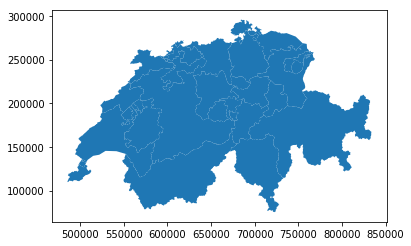

In [60]:
#schauen, wie das aussieht
gdf_kantone.plot()


In [61]:
#Geometrie erstellen mit Koordinaten-Angaben
df_ch['Punkt'] = df_ch.apply(lambda row: Point(row['Longitude'], row['Latitude']), axis=1)


In [62]:
# Geodataframe kreieren
gdf_ch = gpd.GeoDataFrame(df_ch, geometry='Punkt')

In [63]:
# schauen, wie das aussieht
gdf_ch.head(2)

,Unnamed: 0,Unnamed: 0.1,Adresse,Anzahl Bewertungen,Anzahl Sterne,Art der Unterkunft,Ausstattung,Gesamtnote,Hotelpersonal,Komfort,...,Name des Hotels,Ort,Preis/Leistung,Sauberkeit,Kanton,9.5+,ungenügend,Latitude,Longitude,Punkt
0,0,0,"Ohringerstrasse 2, 8472 Seuzach, Schweiz",63.0,NaN,Hotel,9.2,9.1,9.2,9.4,...,Hotel Sonne Seuzach,"47.53626200,8.72925700",8.7,9.5,Zürich,False,False,47.536262,8.729257,POINT (8.729257 47.536262)
1,1,1,"6 Richtistrasse, 8304 Wallisellen, Schweiz",52.0,3,Hotel,7.8,8.1,8.4,8.0,...,B&B Hotel Zürich Wallisellen,"47.41197700,8.59312900",8.1,9.2,Zürich,False,False,47.411977,8.593129,POINT (8.593128999999999 47.411977)


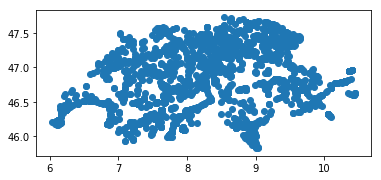

In [64]:
#Die Punkte plotten
gdf_ch.plot()

In [65]:
# sieht nicht wirklich so toll aus. Neuer Versuch, dieses Mal mit der CH-Karte

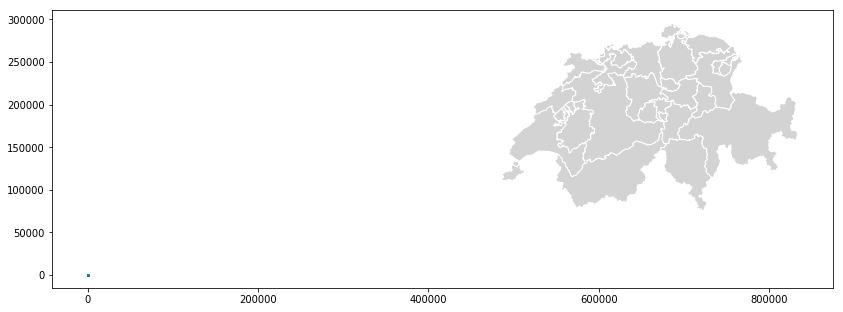

In [66]:
# Schweizer Kantonsgrenzen
ax = gdf_kantone.plot(figsize=(14,10), color='lightgrey', edgecolor='white')
gdf_ch.plot(markersize=3, ax=ax)


In [67]:
# Kantone im Schweizer Koordinatensystem 
gdf_kantone.crs


{'proj': 'somerc',
 'lat_0': 46.95240555555556,
 'lon_0': 7.439583333333333,
 'k_0': 1,
 'x_0': 600000,
 'y_0': 200000,
 'ellps': 'bessel',
 'units': 'm',
 'no_defs': True}

In [68]:
#Geodataframe mit einem richtigem Code initiatilisieren
gdf_ch.crs

In [69]:
# richtige Koordinaten importieren für die Schweiz
gdf_ch.crs = {'init': 'epsg:4326'}


In [70]:
gdf_ch.crs

{'init': 'epsg:4326'}

In [71]:
# Nun zum Schweizer Koordinatensystem (Koordinaten transformieren)
gdf_ch = gdf_ch.to_crs(epsg=21781)


In [72]:
# Für die Beschriftung: Titelschriften definieren
title_font = {
    'family': 'sans-serif',
    'color':  'black',
    'weight': 'bold',
    'size': 20
}
point_names = {
    'family': 'sans-serif',
    'color':  'black',
    'weight': 'normal',
    'size': 10
}

Text(480000, 312000, 'Alle Hotels der Schweiz')

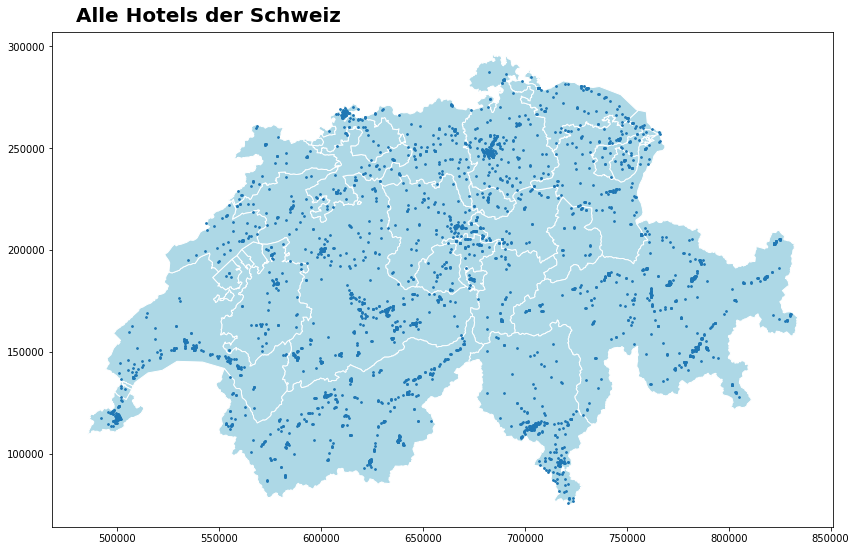

In [73]:
# Alle Hotels der Schweiz auf der CH-Karte anzeigen
ax = gdf_kantone.plot(figsize=(14,10), color='lightblue', edgecolor='white')
gdf_ch.plot(markersize=3, ax=ax)

my_title = "Alle Hotels der Schweiz"
plt.text(480000, 312000, my_title, fontdict=title_font)



### Grafik Nr. 2: «Hotels nach Gesamtnote»

/Users/2nice/.virtualenvs/erstesVE/lib/python3.7/site-packages/pysal/__init__.py:65: VisibleDeprecationWarning: PySAL's API will be changed on 2018-12-31. The last release made with this API is version 1.14.4. A preview of the next API version is provided in the `pysal` 2.0 prelease candidate. The API changes and a guide on how to change imports is provided at https://pysal.org/about
  ), VisibleDeprecationWarning)
/Users/2nice/.virtualenvs/erstesVE/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/Users/2nice/.virtualenvs/erstesVE/lib/python3.7/site-packages/pysal/esda/mapclassify.py:267: RuntimeWarning: invalid value encountered in greater
  

(467989.6331999983, 851259.2407999996, 63944.449940297876, 306981.10571712797)

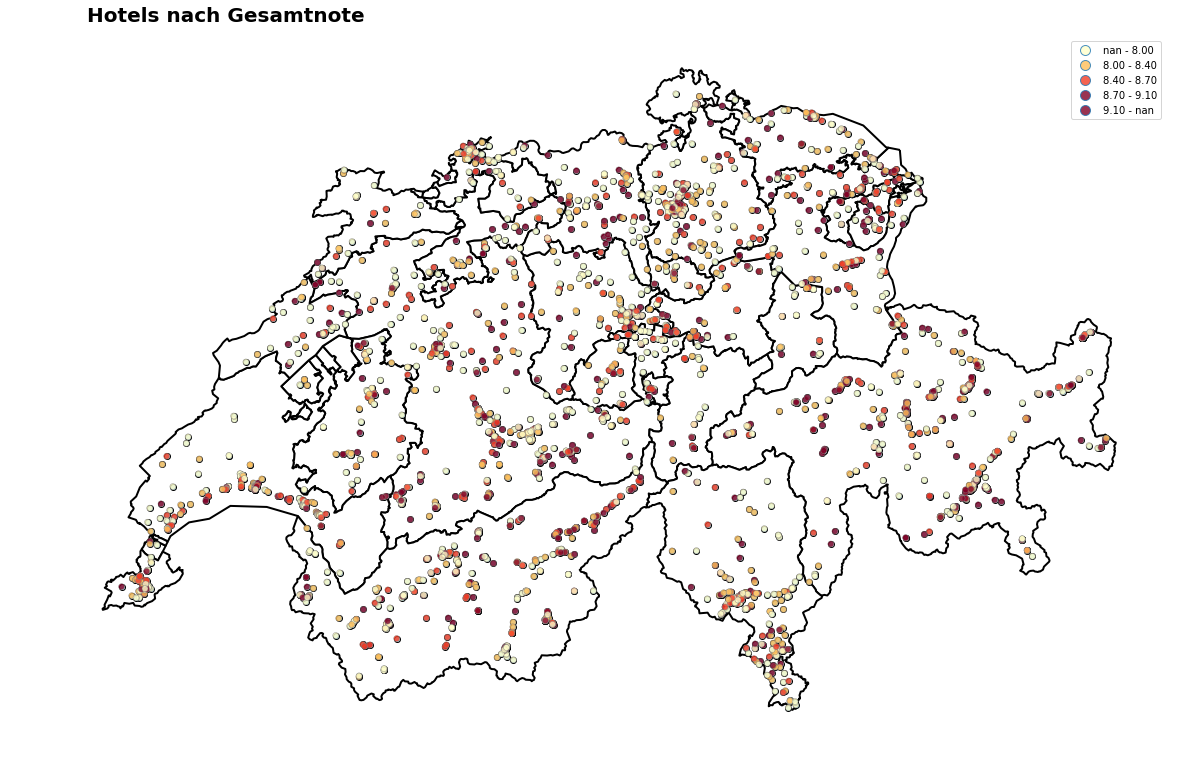

In [74]:
#Code wie oben // Kantone
ax = gdf_kantone.plot(edgecolor='black', color='white', alpha=1, linewidth=2, figsize=(20,13))
gdf_ch.plot(edgecolor='black', facecolor='lightblue', alpha=1, linewidth=1, ax=ax)

#Code für die Hotels, eingefärbt nach der Spalte "Gesamtnote"
gdf_ch.plot(edgecolor='grey', column='Gesamtnote', cmap='YlOrRd', scheme='quantiles', alpha=0.8, linewidth=0.5, ax=ax, legend=True)

my_title = "Hotels nach Gesamtnote"
plt.text(480000, 312000, my_title, fontdict=title_font)

ax.axis('off')

### Grafik Nr. 3: «Gesamtnoten im kantonalen Vergleich» - DataWrapper

Weil sich Grafiken meiner Meinung nach viel schöner und einfacher bei ***DataWrapper*** erstellen lassen, habe ich eine solche aus dem Durchschnitt (Median) der Gesamtnote aller Hotels im kantonalen Vergleich gemacht. JPG siehe Anhang. Und hier noch der Link: 

In [104]:
path = 'Hotelbewertungen im kantonalen Vergleich - kUPMf - Veröffentlichen _ Datawrapper.htm'

### Grafik Nr. 4: «Hotels nach Freundlichkeit»


/Users/2nice/.virtualenvs/erstesVE/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/Users/2nice/.virtualenvs/erstesVE/lib/python3.7/site-packages/pysal/esda/mapclassify.py:267: RuntimeWarning: invalid value encountered in greater
  binIds += (x > l) * (x <= r) * k
/Users/2nice/.virtualenvs/erstesVE/lib/python3.7/site-packages/pysal/esda/mapclassify.py:267: RuntimeWarning: invalid value encountered in less_equal
  binIds += (x > l) * (x <= r) * k
/Users/2nice/.virtualenvs/erstesVE/lib/python3.7/site-packages/numpy/lib/function_base.py:3250: RuntimeWarning: Invalid value encountered in median
  r = func(a, **kwargs)
/Users/2nice/.virtualenvs/ers

(467989.6331999983, 851259.2407999996, 63945.80967067341, 306981.0409680625)

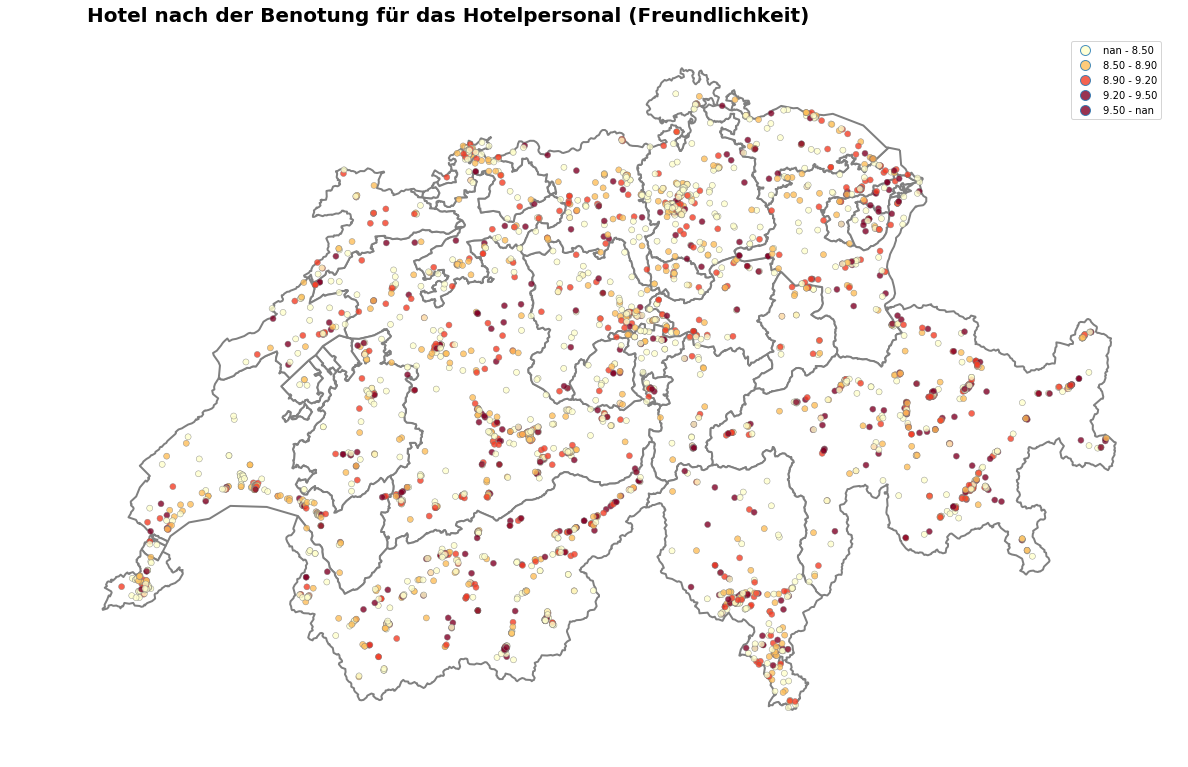

In [107]:
#Selber Code wie oben, für die Landesgrenzen und die Seen
ax = gdf_kantone.plot(edgecolor='grey', color='white', alpha=1, linewidth=2, figsize=(20,13))
#gdf_lakes.plot(edgecolor='grey', facecolor='lightblue', alpha=1, linewidth=1, ax=ax)

#ax = gdf_kantone.plot(edgecolor='grey', color='white', alpha=1, linewidth=2, figsize=(20,13))
#gdf_ch.plot(edgecolor='grey', facecolor='lightblue', alpha=1, linewidth=1, ax=ax)


#Code für die Gemeinden, eingefärbt nach der Spalte "Bevölkerungswachstum"
gdf_ch.plot(edgecolor='grey', column='Hotelpersonal', cmap='YlOrRd', scheme='quantiles', alpha=0.8, linewidth=0.5, ax=ax, legend=True)

my_title = "Hotel nach der Benotung für das Hotelpersonal (Freundlichkeit)"
plt.text(480000, 312000, my_title, fontdict=title_font)

ax.axis('off')

### Grafik Nr. 5: Unterkünfte der Schweiz nach Hotelkategorien

In [87]:
# Zunächst die entsprechenden Daten aus der BeautifulSoup besorgen. 
search_page = 'https://www.booking.com/searchresults.de.html?label=gen173nr-1DCAEoggI46AdIM1gEaCyIAQGYAQe4AQfIAQzYAQPoAQGIAgGoAgO4Ao7M1uMF&sid=8ab37c43178ebf0c33a80beee001db8c&sb=1&src=index&src_elem=sb&error_url=https%3A%2F%2Fwww.booking.com%2Findex.de.html%3Flabel%3Dgen173nr-1DCAEoggI46AdIM1gEaCyIAQGYAQe4AQfIAQzYAQPoAQGIAgGoAgO4Ao7M1uMF%3Bsid%3D8ab37c43178ebf0c33a80beee001db8c%3Bsb_price_type%3Dtotal%26%3B&ss=Schweiz&is_ski_area=0&checkin_year=&checkin_month=&checkout_year=&checkout_month=&no_rooms=1&group_adults=2&group_children=0&b_h4u_keep_filters=&from_sf=1&ss_raw=Schweiz&ac_position=0&ac_langcode=de&ac_click_type=b&dest_id=204&dest_type=country&place_id_lat=46.8182&place_id_lon=8.22751&search_pageview_id=32159247dc4d0059&search_selected=true'

hotels_homepage = requests.get(search_page).text

soup_hotels_homepage = BeautifulSoup(hotels_homepage, 'html.parser')
    
# Kategorien der Unterkünfte 
all_categories = soup_hotels_homepage.find_all('li',{'class':'ia_section '})

# Was uns interessiert, ist im 2. Listenelement: all_categories[1]

In [88]:
# Abfrage Hotelkategorien
alle = []
categories = all_categories[1].find_all('a', {'class':'ia_link'})
for categorie in categories: 
    categorie = categorie.text.split(' ')
    satz = ' '.join(categorie)
    alle.append(satz)

    


In [89]:
category = []
for x in alle:
    anz = x.split(' ').pop(0)
    uk = x.split(' ').pop()
    
    #Dict erstellen
    dict_uk = {'Anzahl': anz, 
           'Unterkunftsart': uk}
    
    category.append(dict_uk)

In [90]:
#Dataframe erstellen
df_category = pd.DataFrame(category)

#Die letzten drei benötige ich nicht
df_category = df_category.head(22)

In [91]:
df_category

,Anzahl,Unterkunftsart
0,10.088,Ferienunterkünfte
1,7.704,Ferienwohnungen
2,1.226,Breakfasts
3,837,Cottages
4,771,Chalets
5,587,Villen
6,587,Ferienhäuser
7,399,Privatzimmer
8,353,Gasthäuser
9,291,Pensionen


In [101]:
# Gesamtsumme der Unterkünfte in der Schweiz bestimmen (dazu zuerst in Integer umwandeln)

# Achtung, zunächst die Punkte ersetzen: 
zahlen_bereinigt = []
for zahl in df_category['Anzahl']:
    zahl = str(zahl).replace(',','')
    zahlen_bereinigt.append(zahl)

df_category['Anzahl'] = zahlen_bereinigt
df_category['Anzahl'] = df_category['Anzahl'].astype(int)
df_category['Anzahl'].sum()

23301

In [102]:
# Barchart nach Verteilung der Unterkunftsart in der Schweiz
x = df_category.groupby('Unterkunftsart')['Anzahl'].mean().sort_values()

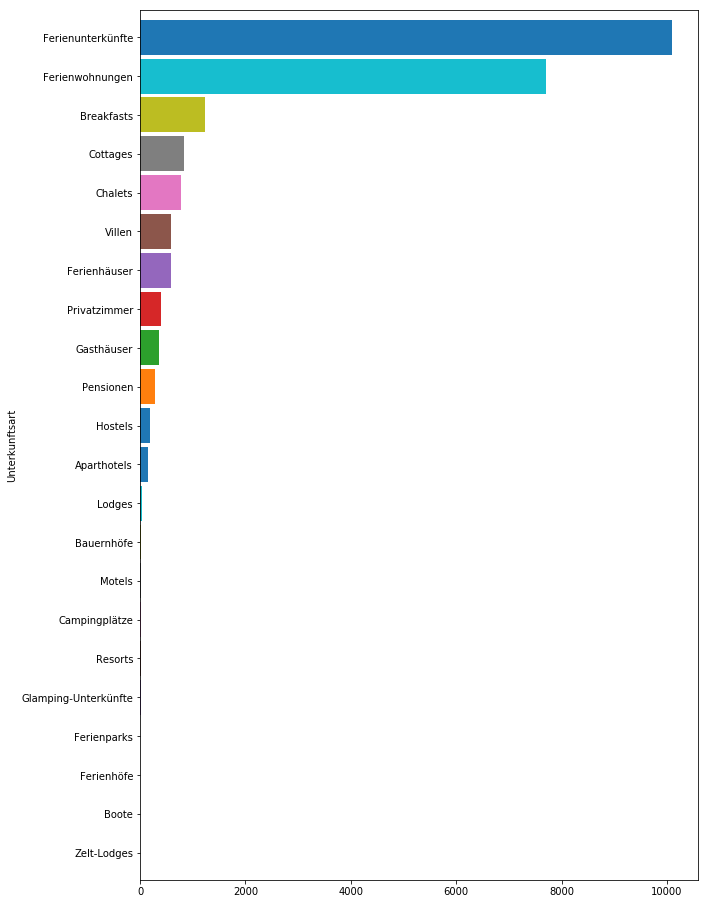

In [109]:
x.plot(kind='barh', figsize=(10, 16), zorder=2, width=0.90)
